#### This notebook presents how to perform maximum-likelihood parameter estimation for multiple neurons.  The neurons depend on each other through a set of weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..'))
sys.path.append(os.path.join(os.getcwd(),'..','code'))
sys.path.append(os.path.join(os.getcwd(),'..','data'))

In [3]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [4]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)


<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

In [5]:
# Number of neurons
nofCells = 2

Reading input-output data:

In [6]:
# creating the path to the data
data_path = os.path.join(os.getcwd(),'..','data')

# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim2.csv'),header = None))

# reading location of spikes
# (lengths of tsp sequences are not equal so reading them line by line)
tsp_list = []
with open(os.path.join(data_path,'tsp2.csv')) as csvfile:
    tspreader = csv.reader(csvfile)
    for row in tspreader:
        tsp_list.append(row)

Extracting a spike train from spike positions:

In [7]:
dt = 0.01
y_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)+1]).astype(int))

Creating filters:

In [8]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [9]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

In [10]:
# Interpolate Post Spike Filter
MSP = auxfun.makeInterpMatrix(len(ht_domain),1)
MSP[0,0] = 0
H_orth = np.dot(MSP,H_orth)

(2,)
(486, 486)


Conditional Intensity (spike rate):
$$\lambda_{\beta}(i) = \exp(K(\beta_k)*Stim + H(\beta_h)*y + \sum_{j\ne i}w_j I(\beta_{I})*y_j) + \mu$$

$$\lambda_{\beta}(i) = \exp(M_k\beta_k + M_h \beta_h + Y w + \mu)$$

Creating a matrix of covariates:

In [11]:
M_k = lk.construct_M_k(Stim,K,dt)

In [12]:
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))



In [13]:
# creating a matrix of output covariates
Y = np.array(y_list).T

<!---Simulating a neuron spike trains:-->

In [14]:
# tsp_list = []
# for i in range(nofCells):
#    tsp_list.append(auxfun.simSpikes(np.hstack((coeff_k,coeff_h)),M,dt))

In [15]:
M_list = []
for i in range(len(M_h_list)):
    # exclude the i'th spike-train
    M_list.append(np.hstack((M_k,M_h_list[i],np.delete(Y,i,1),np.ones((M_k.shape[0],1)))))
    #M_list.append(np.hstack((M_k,M_h_list[i],np.ones((M_h.shape[0],1)))))

Conditional intensity as a function of the covariates:
$$ \lambda_{\beta} = \exp(M\beta) $$

Create a Poisson process model with this intensity:

Setting initial parameters:

In [16]:
coeff_k0 = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])
coeff_h0 = np.zeros((5,))
coeff_w0 = np.zeros((nofCells,))
mu_0 = 0

pars0 = np.hstack((coeff_k0,coeff_h0,coeff_w0,mu_0))
pars0 = np.hstack((coeff_k0,coeff_h0,mu_0))
pars0 = np.zeros((17,))

Fitting the likelihood:

In [17]:
res_list = []
for i in range(len(y_list)):
    model = PP.PPModel(M_list[i].T,dt = dt/100)
    res_list.append(model.fit(y_list[i],start_coef = pars0,maxiter = 500, method = 'L-BFGS-B'))

25.0
-2370.91555267
-2651.66031375
-2586.84402508
-2790.27181698
-2944.31850754
-3064.36090651
-3142.99215553
-3219.60005413
-3263.66116582
-3383.31699087
-3438.24346929
-3491.1313386
-3530.93088474
-3598.41697668
-3665.57706446
-3632.92946272
-3691.88463173
-3717.88464084
-3740.41582874
-3746.57514425
-3749.53197558
-3752.08731379
-3758.09575081
-3772.35362298
-3794.4806474
-3831.87625386
-3886.7354796
-3922.49715109
-3956.50693795
-3992.33699331
-4125.18462257
-4413.87686531
-3618.3163967
-4489.29639788
-4712.42177482
-4846.83333052
-4941.95107109
-4976.29120482
-4985.05683941
-4990.6265096
-4980.08277636
-4991.13691361
-4991.81479836
-4992.74356026
-4993.32243034
-4993.8265394
-4994.28515079
-4994.93743572
-4995.92758122
-4998.08679556
-5001.80665683
-5009.3330824
-5028.92469084
-5063.46188559
-5100.54858457
-5082.19656408
-5134.97708252
-5169.41107218
-5176.02593733
-5182.78927326
-5190.64548854
-5195.61328077
-5206.827882
-5211.64687652
-5215.66415765
-5216.459103
-5216.73117095
-

/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:171: OptimizeWarning: Unknown solver options: maxfev
  res = optimize.minimize(self.negLogL,start_coef,jac = self.gradNegLogL,hess = self.hessNegLogL, args = y, options = opts, method = method)


Specifying the true parameters:

In [18]:
k_coeff = np.array([0.061453, 0.284916, 0.860335, 1.256983, 0.910615, 0.488660, -0.887091, 0.097441, 0.026607, -0.090147])
h_coeff = np.array([-15.18,38.24,-67.58,-14.06,-3.36])

Estimated dc for neuron 0: 3.10101102304
Estimated dc for neuron 1: 3.14900338762


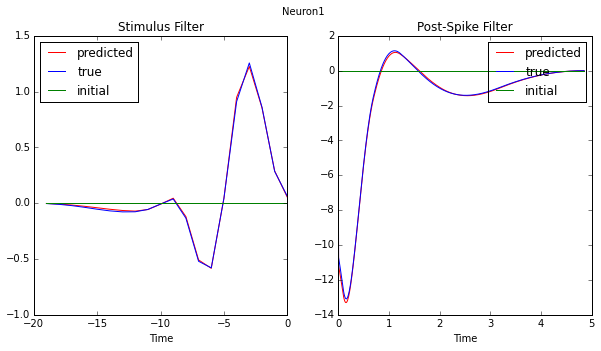

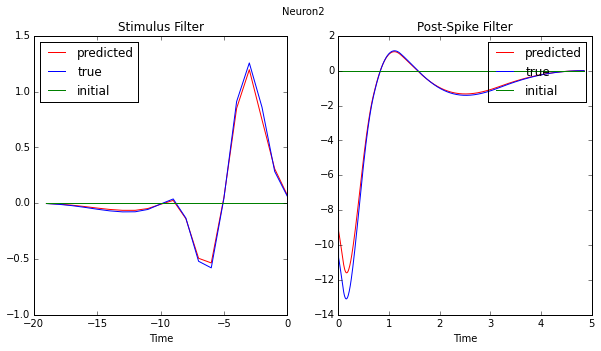

In [19]:
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = res_list[i].x[10:15]
    print('Estimated dc for neuron '+str(i)+': '+str(res_list[i].x[-1]))
    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted),'r',label = 'predicted')
    axs[0].set_title('Stimulus Filter')
    axs[0].hold(True)
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff),'b',label = 'true')
    axs[0].plot(-kt_domain[::-1],np.dot(K,pars0[:10]),'g',label = 'initial')
    axs[0].set_xlabel('Time')
    axs[0].legend(loc = 'upper left')
    axs[1].set_title('Post-Spike Filter')
    axs[1].plot(ht_domain,np.dot(H_orth,h_coeff_predicted),'r',label = 'predicted')
    axs[1].plot(ht_domain,np.dot(H_orth,h_coeff),'b',label = 'true')
    axs[1].plot(ht_domain,np.dot(H_orth,coeff_h0[:H_orth.shape[1]]),'g',label = 'initial')
    axs[1].set_title('Post-Spike Filter')
    axs[1].set_xlabel('Time')
    axs[1].legend(loc = 'upper right')

Extracting the weight matrix:

In [20]:
W = np.array([np.hstack((res_list[i].x[-(nofCells):-nofCells+i],0,res_list[i].x[-nofCells+i:-1])) for i in range(len(res_list))])
print(W)

[[ 0.         -0.03272112]
 [-0.08846552  0.        ]]


Note: the stimulus and the post-spike estimates can be different for different neurons.

Note: there might be some scale issue. Need to normalize these weights in some way.